In [1]:
%load_ext autoreload
%autoreload 2

import os
import copy
import torch
import joblib
import training
import numpy as np
import torch.nn as nn
import global_settings as global_settings
from matplotlib import gridspec
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from training import train

# ------------------------------------------------

ds_name_dict = {
    "KUL" : "KUL auditory attention",
    "GME" : "GME int/ext attention",
    "CHO" : "CHO motor imagery",
}

if torch.cuda.is_available():
    dtype_float = torch.cuda.FloatTensor
    dtype_long = torch.cuda.LongTensor
else:
    dtype_float = torch.FloatTensor
    dtype_long = torch.LongTensor


Tensorflow not install, you could not use those pipelines
To use the get_shape_from_baseconcar, InputShapeSetterEEG, BraindecodeDatasetLoaderyou need to install `braindecode`.`pip install braindecode` or Please refer to `https://braindecode.org`.


### Calculating accuracies

In [2]:
res_dict = {}

for dh in global_settings.data_handlers:
    print(">>> ", dh.ds_name)
    ds_name = dh.ds_name

    res_dict[ds_name] = {}

    for params in global_settings.CV_params:
        ftm_name = "raw" + training.utils.dict_to_str(params)
        print("   >>> ", ftm_name)

        res_dict[ds_name][ftm_name] = {}

        for idx in range(dh.num_subjects):

            res_dict[ds_name][ftm_name][idx] = {}

            data_shape = dh.get_transformed_data_shape()

            if data_shape is None:
                print(">> shape is None: ", idx)
                break

            num_chn = data_shape[-2]
            num_time_points = data_shape[-1]

            if "conv_layers" in params:
                num_conv_layers = True
            else:
                num_conv_layers = None

            model, checkpoint = training.utils.load_model(dh, params, num_chn=num_chn, num_data_points=num_time_points,
                                                        subject=idx, return_dict=True, show_errors=True, epochs=False,
                                                        num_conv_layers=num_conv_layers)
            model.eval()

            if checkpoint is None:
                print(">> checkpoint is None", idx)
                continue

            if torch.cuda.is_available():
                device = torch.device("cuda")
            else:
                device = torch.device("cpu")

            X_test = None
            y_test = None

            # ------------------------------------------

            data = dh.get_X_y_separate(idx)

            X_subj, y_subj, _ = data

            if type(y_subj) != np.ndarray:
                y_subj = np.array(y_subj)

            X_test = torch.from_numpy(X_subj).type(dtype_float)
            y_test = torch.from_numpy(y_subj).type(dtype_long)

            test_ds = torch.utils.data.TensorDataset(X_test, y_test.long())
            test_loader = DataLoader(test_ds, batch_size=global_settings.batch_size)

            criterion = nn.CrossEntropyLoss()

            test_acc, _, preds, targets = train.eval_loop(model, test_loader, criterion, rereference=True, standardize=True, return_preds_and_targets=True)

            res_dict[ds_name][ftm_name][idx]['test_preds'] = preds
            res_dict[ds_name][ftm_name][idx]['test_targets'] = targets

            # ---------------------------------------------------------
            # precalculate scores for convenvience - subject level

            preds = [item for sublist in preds for item in sublist]
            targets = [item for sublist in targets for item in sublist]

            acc = accuracy_score(targets, preds)
            prec = precision_score(targets, preds, average='macro')
            rec = recall_score(targets, preds, average='macro')
            fsc = f1_score(targets, preds, average='macro')

            res_dict[ds_name][ftm_name][idx]['test_acc'] = acc
            res_dict[ds_name][ftm_name][idx]['test_prec'] = prec
            res_dict[ds_name][ftm_name][idx]['test_rec'] = rec
            res_dict[ds_name][ftm_name][idx]['test_fsc'] = fsc


>>>  GME
   >>>  raw_bs128_val_size0_do0.25_seed_per_fold_nr0_CAR_per_sample
   >>>  raw_bs128_val_size0_do0.25_seed_per_fold_nr1_CAR_per_sample
   >>>  raw_bs128_val_size0_do0.25_seed_per_fold_nr2_CAR_per_sample
   >>>  raw_bs128_val_size0_do0.25_seed_per_fold_nr3_CAR_per_sample
   >>>  raw_bs128_val_size0_do0.25_seed_per_fold_nr4_CAR_per_sample
   >>>  raw_bs128_val_size0_do0.25_seed_per_fold_nr5_CAR_per_sample
   >>>  raw_bs128_val_size0_do0.25_seed_per_fold_nr6_CAR_per_sample
   >>>  raw_bs128_val_size0_do0.25_seed_per_fold_nr7_CAR_per_sample
   >>>  raw_bs128_val_size0_do0.25_seed_per_fold_nr8_CAR_per_sample
   >>>  raw_bs128_val_size0_do0.25_seed_per_fold_nr9_CAR_per_sample


### Total accuracy per dataset

(10,)


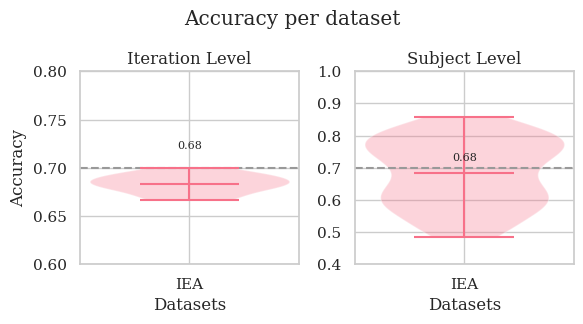

In [3]:

ds_title_map = {
    "CHO": "MI",
    "KUL": "AA",
    "GME": "IEA",
}

conditions = ["Iteration", "Subject"] 
fig, axes = plt.subplots(nrows=1, ncols=len(conditions), figsize=(3*len(conditions), 3)) 

for cond_idx, calc_acc_per in enumerate(conditions):

    accs_per_ds = []
    ds_names_original = []

    if calc_acc_per == "Subject":
        for dh in global_settings.data_handlers:
            ds_accs = []
            ds_names_original.append(ds_title_map[dh.ds_name])
            ds_name = dh.ds_name

            for CV in res_dict[ds_name].keys():
                
                for subj in res_dict[dh.ds_name][CV].keys():

                    preds = res_dict[ds_name][CV][subj]['test_preds']
                    targets = res_dict[ds_name][CV][subj]['test_targets']

                    # flatten lists
                    preds = [item for sublist in preds for item in sublist]
                    targets = [item for sublist in targets for item in sublist]

                    test_acc = accuracy_score(targets, preds)
                    ds_accs.append(test_acc)
                
            accs_per_ds.append(ds_accs)

    elif calc_acc_per == "Iteration":
        
        for dh in global_settings.data_handlers:
            ds_accs = []
            ds_names_original.append(ds_title_map[dh.ds_name])
            ds_name = dh.ds_name

            for CV in res_dict[ds_name].keys():
                
                all_preds = []
                all_targets = []

                for subj in res_dict[dh.ds_name][CV].keys():

                    preds = res_dict[ds_name][CV][subj]['test_preds']
                    targets = res_dict[ds_name][CV][subj]['test_targets']

                    # flatten lists
                    preds = [item for sublist in preds for item in sublist]
                    targets = [item for sublist in targets for item in sublist]

                    all_preds += preds
                    all_targets += targets
            
                test_acc = accuracy_score(all_targets, all_preds)
                ds_accs.append(test_acc)
            
            accs_per_ds.append(ds_accs)

            print(np.array(ds_accs).shape)

    else: # batch

        for dh in global_settings.data_handlers:
            ds_accs = []
            ds_names_original.append(ds_title_map[dh.ds_name])
            ds_name = dh.ds_name

            for CV in res_dict[ds_name].keys():
                
                for subj in res_dict[dh.ds_name][CV].keys():

                    preds = res_dict[ds_name][CV][subj]['test_preds']
                    targets = res_dict[ds_name][CV][subj]['test_targets']

                    for idx in range(len(preds)): # batches

                        batch_preds = preds[idx]
                        batch_targets = targets[idx]

                        test_acc = accuracy_score(batch_preds, batch_targets)
                        ds_accs.append(test_acc)
                
            accs_per_ds.append(ds_accs)

    # ----------------------------------------------------------------------------------

    if len(conditions) > 1:
        axis = axes[cond_idx]
    else:
        axis = axes

    sort = False

    ds_names = copy.copy(ds_names_original)

    means = [np.mean(accs) for accs in accs_per_ds]

    if sort:
        indices = np.argsort(means)
    else:
        indices = [i for i in range(0, len(means))]

    ds_names = np.array(ds_names)[indices]

    accs_per_ds = [accs_per_ds[i] for i in indices]

    val = 0.6
    axis.axhline(y=0.7, color=(val, val, val), linestyle='--')

    axis.violinplot(accs_per_ds, widths=0.7, showmeans=True, showextrema=True, showmedians=False)

    axis.set_xticks([i+1 for i in range(len(ds_names))])  
    axis.set_xticklabels(ds_names)  

    for i, mean in enumerate(means):
        axis.text(i+1, mean + mean*0.05, f'{mean:.2f}', horizontalalignment='center', verticalalignment='bottom', fontsize=8)

    if calc_acc_per == "Iteration":
        axis.set_ylim(0.6, 0.8)
    else:
        axis.set_ylim(0.4, 1.0)

    if cond_idx == 0:
        axis.set_ylabel("Accuracy")  

    axis.set_title(f"{calc_acc_per} Level")
    axis.set_xlabel("Datasets")

plt.tight_layout()
plt.suptitle("Accuracy per dataset", y=1.075)
plt.show()

### Accuracy per subject

(10, 10)


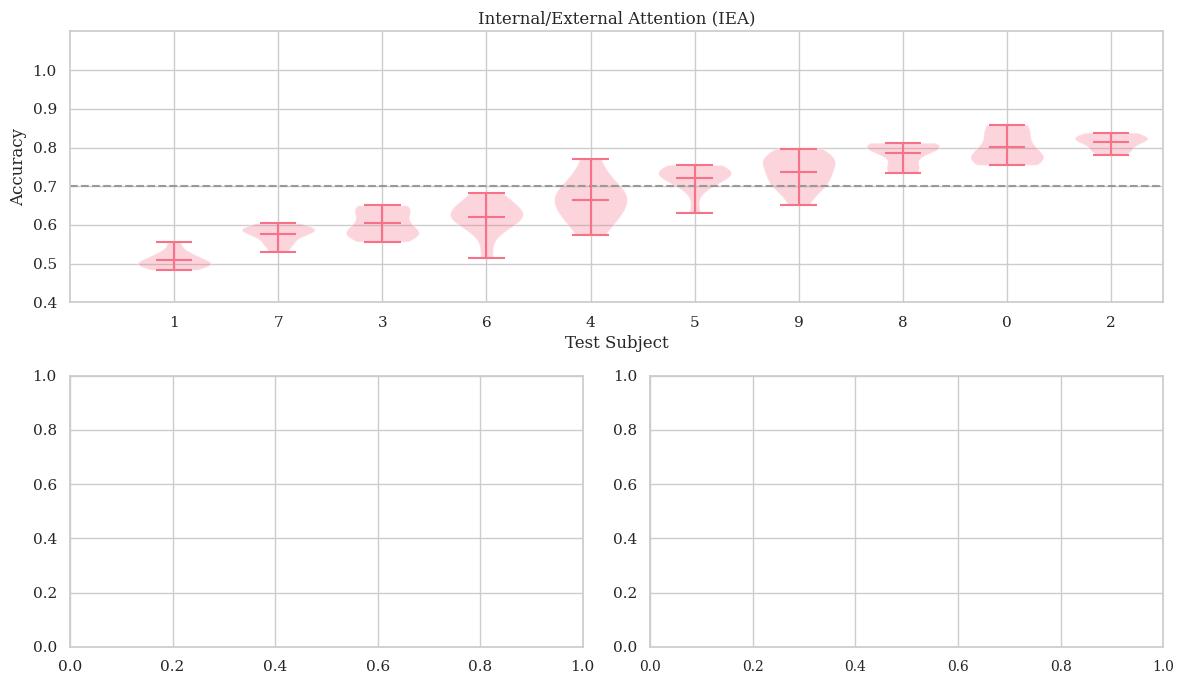

In [4]:
ds_title_map = {
    "CHO": "Motor Imagery (MI)", 
    "KUL": "Auditory Attention (AA)",
    "GME": "Internal/External Attention (IEA)"
}

def plot_acc_per_subject(CV_params, data_handlers_,  metric="fsc", title="", sort=True):

    accs_per_ds = []

    for dh in data_handlers_:
        accs_per_subj = []

        for subj in range(dh.num_subjects):
            accs = []

            for params in CV_params:
                cv_name = "raw" + training.utils.dict_to_str(params)

                test_accs = res_dict[dh.ds_name][cv_name][subj][f'test_{metric}']
                accs.append(test_accs)

            accs_per_subj.append(accs)

        print(np.array(accs_per_subj).shape)
        accs_per_ds.append(accs_per_subj)

    # -------------------------------------------------

    # Create a figure and gridspec layout
    fig = plt.figure(figsize=(12, 7))
    gs = gridspec.GridSpec(2, 2, height_ratios=[3.5, 3.5])

    # Create subplots
    ax1 = plt.subplot(gs[0, :])  # Single subplot in the first row
    ax2 = plt.subplot(gs[1, 0])  # First subplot in the second row
    ax3 = plt.subplot(gs[1, 1])  # Second subplot in the second row

    axes = [ax1, ax2, ax3]

    # -------------------------------------------------

    for idx, dh in enumerate(data_handlers_):
        axis = axes[idx]

        val = 0.6
        axis.axhline(y=0.7, color=(val, val, val), linestyle='--')

        ds_accs = accs_per_ds[idx]

        ds_acc_means = []
        for accs in ds_accs:
            ds_acc_means.append(np.mean(accs))

        if sort:
            sort_indices = np.argsort(ds_acc_means)
        else:
            sort_indices = [i for i in range(len(ds_acc_means))] # np.argsort(ds_acc_means)
        ds_accs = [ds_accs[i] for i in sort_indices]
        subj_indices = [str(si) for si in sort_indices]

        axis.set_title(f"{ds_title_map[dh.ds_name]}")

        metric_map = {
            "acc": "Accuracy",
            "prec": "Precision",
            "fsc":  "F-Score",
            "rec": "Recall",
        }

        axis.set_ylabel(metric_map[metric])
        axis.set_ylim(0.4, 1)
        axis.set_yticks([i for i in np.arange(0.0, 1.1, 0.1)])

        axis.set_xlabel("Test Subject")

        axis.violinplot(ds_accs, showmeans=True, showextrema=True, showmedians=False, widths=0.7, vert=True)
        # axis.boxplot(ds_accs, vert=True, showmeans=True)  

        axis.set_xticks(np.arange(1, dh.num_subjects+1), labels=subj_indices)
        axis.set_xlim(0, dh.num_subjects + 0.5)  # Adjust x-axis limits
        axis.set_ylim(0.4, 1.1)

    plt.xticks(fontsize=10) 
    plt.tight_layout()
    plt.show()

sort = True

plot_acc_per_subject(global_settings.CV_params, global_settings.data_handlers, metric="acc", title="All", sort=sort)


(10, 10)


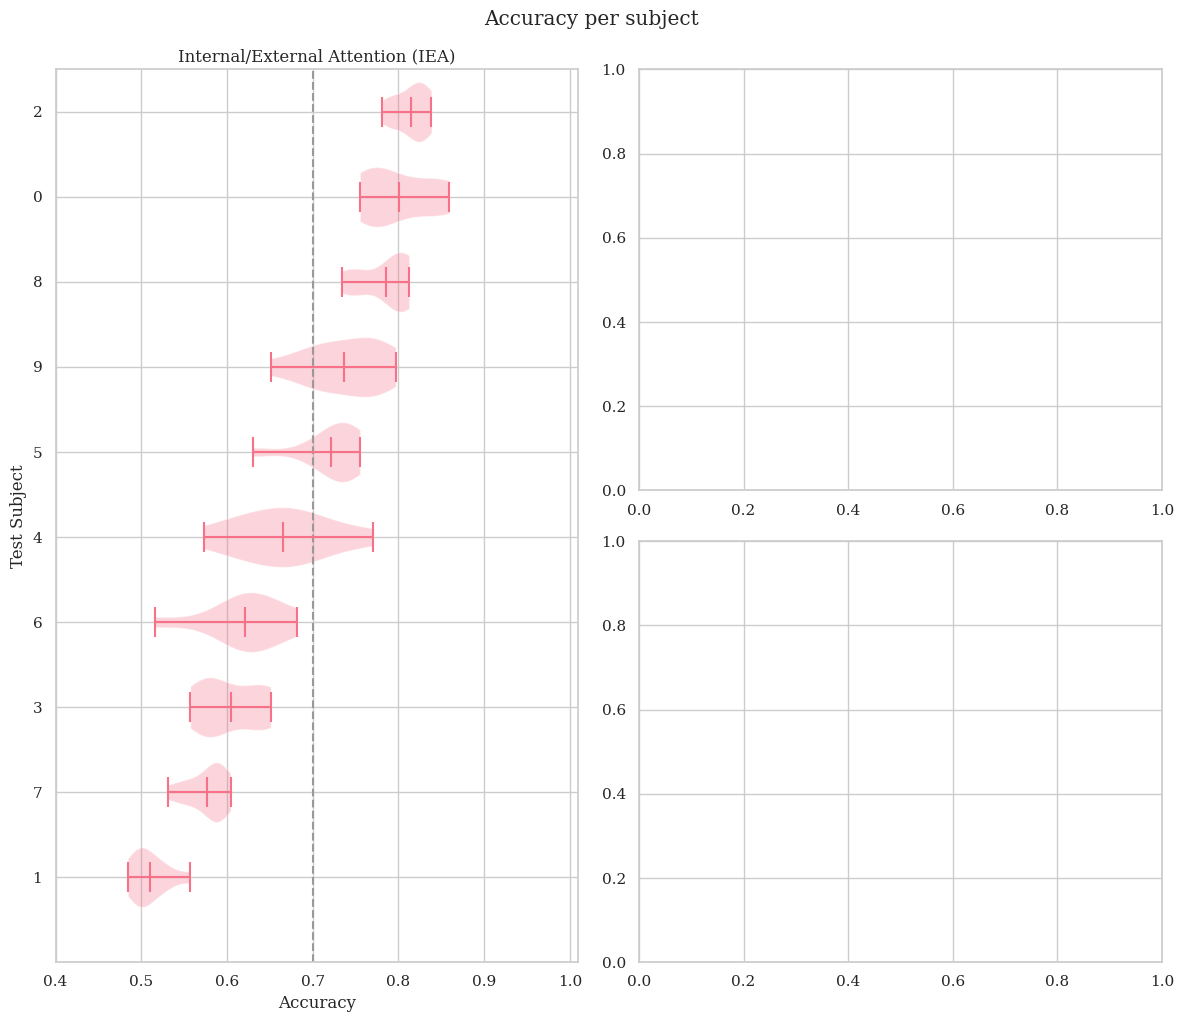

In [5]:
ds_title_map = {
    "CHO": "Motor Imagery (MI)", 
    "KUL": "Auditory Attention (AA)",
    "GME": "Internal/External Attention (IEA)"
}

def plot_acc_per_subject(CV_params, data_handlers_,  metric="fsc", title="", sort=True):

    accs_per_ds = []

    for dh in data_handlers_:
        accs_per_subj = []

        for subj in range(dh.num_subjects):
            accs = []

            for params in CV_params:
                cv_name = "raw" + training.utils.dict_to_str(params)

                test_accs = res_dict[dh.ds_name][cv_name][subj][f'test_{metric}']
                accs.append(test_accs)

            accs_per_subj.append(accs)

        print(np.array(accs_per_subj).shape)
        accs_per_ds.append(accs_per_subj)

    # -------------------------------------------------

    # Create a figure and gridspec layout
    fig = plt.figure(figsize=(12, 10))
    gs = gridspec.GridSpec(2, 2, height_ratios=[2, 2])

    # Create subplots
    ax1 = plt.subplot(gs[:, 0])  # Single subplot spanning two rows in the first column
    ax2 = plt.subplot(gs[0, 1])  # First subplot in the first row of the second column
    ax3 = plt.subplot(gs[1, 1])  # Second subplot in the second row of the second column

    axes = [ax1, ax2, ax3]

    # -------------------------------------------------

    for idx, dh in enumerate(data_handlers_):
        axis = axes[idx]

        val = 0.6
        # axis.axhline(x=0.7, color=(val, val, val), linestyle='--')
        axis.axvline(x=0.7, color=(val, val, val), linestyle='--')

        ds_accs = accs_per_ds[idx]

        ds_acc_means = []
        for accs in ds_accs:
            ds_acc_means.append(np.mean(accs))

        if sort:
            sort_indices = np.argsort(ds_acc_means)
        else:
            sort_indices = [i for i in range(len(ds_acc_means))] # np.argsort(ds_acc_means)
        ds_accs = [ds_accs[i] for i in sort_indices]
        subj_indices = [str(si) for si in sort_indices]

        axis.set_title(f"{ds_title_map[dh.ds_name]}")

        metric_map = {
            "acc": "Accuracy",
            "prec": "Precision",
            "fsc":  "F-Score",
            "rec": "Recall",
        }

        axis.set_xlabel(metric_map[metric])
        axis.set_xticks([i for i in np.arange(0.0, 1.1, 0.1)])

        axis.set_ylabel("Test Subject")

        axis.violinplot(ds_accs, showmeans=True, showextrema=True, showmedians=False, widths=0.7, vert=False)
        # # axis.boxplot(ds_accs, vert=True, showmeans=True)  

        axis.set_yticks(np.arange(1, dh.num_subjects+1), labels=subj_indices)
        axis.set_ylim(0, dh.num_subjects + 0.5)  # Adjust x-axis limits
        axis.set_xlim(0.4, 1.01)

    # plt.xticks(fontsize=10) 
    plt.tight_layout()
    plt.suptitle("Accuracy per subject", y=1.02)
    plt.show()

sort = True

plot_acc_per_subject(global_settings.CV_params, global_settings.data_handlers, metric="acc", title="All", sort=sort)


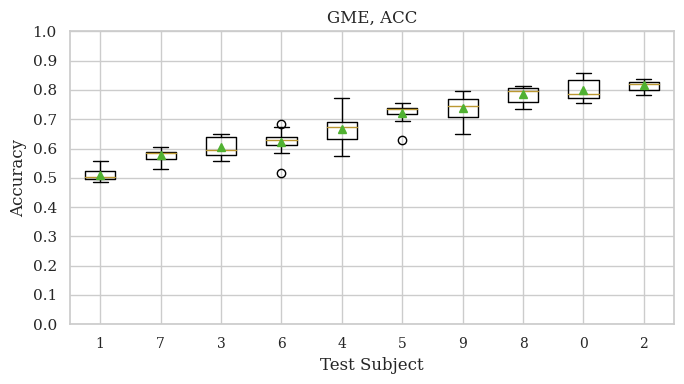

In [6]:

def plot_acc_per_subject(CV_params, data_handlers_,  metric="acc", title="", sort=True):

    accs_per_ds = []

    for dh in data_handlers_:
        accs_per_subj = []

        for subj in range(dh.num_subjects):
            accs = []

            for params in CV_params:
                cv_name = "raw" + training.utils.dict_to_str(params)

                test_accs = res_dict[dh.ds_name][cv_name][subj][f'test_{metric}']
                accs.append(test_accs)

            accs_per_subj.append(accs)
        accs_per_ds.append(accs_per_subj)

    _, ax = plt.subplots(len(data_handlers_), 1, figsize=(7, 4*len(data_handlers_)))

    for idx, dh in enumerate(data_handlers_):
        try:
            axis = ax[idx]
        except:
            axis = ax

        ds_accs = accs_per_ds[idx]

        ds_acc_means = []
        for accs in ds_accs:
            ds_acc_means.append(np.mean(accs))

        if sort:
            sort_indices = np.argsort(ds_acc_means)
        else:
            sort_indices = [i for i in range(len(ds_acc_means))] # np.argsort(ds_acc_means)
        ds_accs = [ds_accs[i] for i in sort_indices]
        subj_indices = [str(si) for si in sort_indices]

        axis.set_title(f"{dh.ds_name}, {metric.upper()}")

        axis.set_ylabel("Accuracy")
        axis.set_ylim(0.4, 1)
        axis.set_yticks([i for i in np.arange(0.0, 1.1, 0.1)])

        axis.set_xlabel("Test Subject")

        axis.boxplot(ds_accs, showmeans=True, labels=subj_indices)

    plt.xticks(fontsize=10) # , rotation=90)
    plt.tight_layout()
    plt.show()

sort = True

plot_acc_per_subject(global_settings.CV_params, global_settings.data_handlers, metric="acc", title="All", sort=sort)


### Accuracy per CV iteration

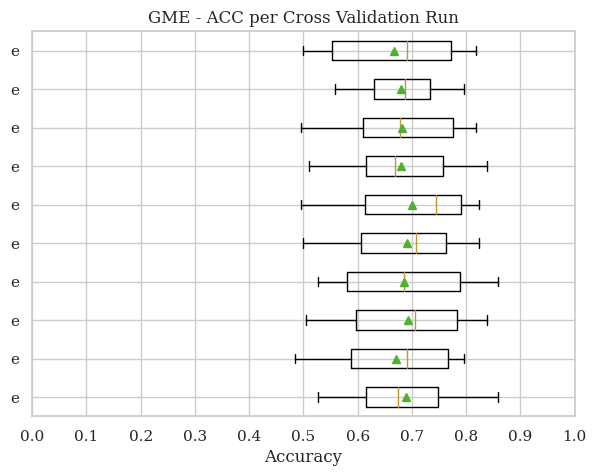

In [7]:

metric = "acc"

if metric == 'acc':
    labels = [None]
else:
    labels = [0,1,None]


for ds_name in res_dict.keys():
    for label in labels:

        accs_per_CV = []
        CV_names_original = []

        for CV in res_dict[ds_name].keys():

            CV_nr = CV[-1]

            CV_accs = []
            CV_names_original.append(CV_nr)
            
            for subj in res_dict[ds_name][CV].keys():
                if label is not None:
                    test_accs = [res_dict[ds_name][CV][subj][f'test_{metric}_c{label}']]
                else:
                    test_accs = [res_dict[ds_name][CV][subj][f'test_{metric}']]

                if test_accs: 
                    CV_accs.append(test_accs[-1])

            accs_per_CV.append(CV_accs)
        
        # ----------------------------------------------------------------------------------

        CV_names = [name for name in CV_names_original]

        height = len(CV_names)*0.5
        fig, ax = plt.subplots(1, 1, figsize=(7, height))

        CV_accs = accs_per_CV

        sort_by_mean_acc = False
        if sort_by_mean_acc:
            means = [np.mean(accs) for accs in ftm_accs]
            indices = np.argsort(means)
            ftm_names = np.array(ftm_names)[indices]
            ftm_accs = [ftm_accs[i] for i in indices]  # ftm_accs[indices,:]

        axis = ax

        axis.boxplot(CV_accs, vert=False, showmeans=True)

        axis.set_yticks([i+1 for i in range(len(CV_names))])
        axis.set_yticklabels(CV_names)
        axis.set_xticks([i for i in np.arange(0, 1.1, 0.1)])
        axis.set_xlabel("Accuracy")
        axis.set_xlim(0, 1)

        if label is None:
            axis.set_title(f"{ds_name} - {metric.upper()} per Cross Validation Run") # : {ds_str}")
        else:
            axis.set_title(f"Class {label}") 

        # plt.tight_layout()
        plt.show()